In [ ]:
import pandas as pd

In [ ]:
train = pd.read_csv("./dataset/train.csv")
test = pd.read_csv("./dataset/test.csv")
books = pd.read_csv("./dataset/cleaned_books.csv")
users = pd.read_csv("./dataset/user_info.csv")

In [ ]:
users.rename(columns={'User_Id': 'user_id', 'Location': 'location', 'Age': 'age'}, inplace=True)
train = train.rename(columns={'User_Id': 'user_id', 'Rating': 'rating', 'Book_Id': 'book_id'})
test = test.rename(columns={'User_Id': 'user_id', 'Book_Id': 'book_id'})

In [ ]:
train['rating'] = train['rating'].apply(lambda x: 10 if x > 10 else x)

In [ ]:
validation = pd.read_csv("./test_data.csv")

In [ ]:
from surprise import Reader, Dataset, SVD

In [ ]:
reader = Reader(rating_scale=(1, 10))

In [ ]:
data = Dataset.load_from_df(train[['user_id', 'book_id', 'rating']], reader)

In [ ]:
def process(_n_epochs, _n_factors, _lr_all, _reg_all):
    algo = SVD(n_epochs=_n_epochs, n_factors=_n_factors, lr_all=_lr_all, reg_all=_reg_all)
    algo.fit(data.build_full_trainset())
    validation['svd_rating'] = validation.apply(lambda row: algo.predict(row['user_id'], row['book_id']).est,
                                            axis=1)
    # rmse
    rmse = ((validation['svd_rating'] - validation['actual_rating']) ** 2).mean() ** .5
    print(f"n_epochs: {_n_epochs}, n_factors: {_n_factors}, lr_all: {_lr_all}, reg_all: {_reg_all}, rmse: {rmse}")

process(100, 10, 0.001, 0.05)

In [ ]:
books = books[['book_id', 'title', 'author', 'year', 'publisher']]

In [ ]:
print(train.shape)
train_df = train.merge(books, on="book_id", how="left")
print(train_df.shape)
train_df = pd.merge(train_df, users, on='user_id', how='left')
print(train_df.shape)

In [ ]:
print(validation.shape)
validation_df = validation.merge(books, on="book_id", how="left")
print(validation_df.shape)
validation_df = pd.merge(validation_df, users, on='user_id', how='left')
print(validation_df.shape)

In [ ]:
train_df.head()

In [ ]:
train_df.isna().sum()

In [ ]:
# replace missing age with median age
train_df['age'] = train_df['age'].fillna(train_df['age'].median())
validation_df['age'] = validation_df['age'].fillna(validation_df['age'].median())

In [ ]:
print(train_df['year'].max())
print(train_df['year'].min())

In [ ]:
# replace the year below 1700 and above 2023 with median year
train_df['year'] = train_df['year'].apply(lambda x: train_df['year'].median() if x < 1700 or x > 2023 else x)

In [ ]:
validation_df['year'] = validation_df['year'].apply(lambda x: validation_df['year'].median() if x < 1700 or x > 2023 else x)

In [ ]:
train_df.isna().sum()

In [ ]:
validation_df.isna().sum()

In [ ]:
num_cols = ['year', 'age']
cat_cols = ['author', 'publisher', 'user_id', 'book_id']
text_cols = ['title']

In [ ]:
# fill numeric columns with median
for col in num_cols:
    train_df[col] = train_df[col].fillna(train_df[col].median())
    validation_df[col] = validation_df[col].fillna(validation_df[col].median())

# fill categorical columns with mode
for col in cat_cols:
    train_df[col] = train_df[col].fillna(train_df[col].mode()[0])
    validation_df[col] = validation_df[col].fillna(validation_df[col].mode()[0])

# fill text columns with empty string
for col in text_cols:
    train_df[col] = train_df[col].fillna('')
    validation_df[col] = validation_df[col].fillna('')

In [ ]:
train_df.isna().sum()

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [ ]:
from nltk.corpus import stopwords

from nltk import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()

In [ ]:
from nltk import word_tokenize
from unidecode import unidecode

import re


def preprocess(text):
  text = str(text).lower().strip()
  text = unidecode(text)
  text = re.sub(r'(.)\1\1+', r'\1\1', text)
  text = re.sub("[^a-zA-Z0-9]", " ", text)
  text = word_tokenize(text)
  text = [item for item in text if item not in stop_words]
  text = [lemma.lemmatize(w) for w in text]
  text = [i for i in text if len(i) > 1]
  text = ' '.join(text)
  return text

print(preprocess("This is à bôók title"))

In [ ]:
train_df['title'] = train_df['title'].apply(lambda x: preprocess(x))
validation_df['title'] = validation_df['title'].apply(lambda x: preprocess(x))

In [ ]:
validation_df.head()

In [ ]:
from keras.layers import Dense, Layer
import tensorflow as tf

class Attention(Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
vocab_size = 100
embedding_dim = 100
max_length = 100
trunc_type = "post"
padding_type = "post"
oov_token = "<OOV>"
num_epochs = 50
batch_size = 128

In [33]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

scaler = StandardScaler()
encoder = LabelEncoder()

In [34]:
X_train = pd.DataFrame()
X_validation = pd.DataFrame()

In [35]:
X_train[num_cols] = scaler.fit_transform(train_df[num_cols])
X_validation[num_cols] = scaler.fit_transform(validation_df[num_cols])

In [36]:
X_train[cat_cols] = train_df[cat_cols].apply(encoder.fit_transform)
X_validation[cat_cols] = validation_df[cat_cols].apply(encoder.fit_transform)

In [37]:
X_train.head()

,year,age,author,publisher,user_id,book_id
0,-0.273155,5.429412,20921,3488,43918,24173
1,1.042328,-0.110136,19891,7695,20500,141596
2,-1.588637,-0.791926,39390,5105,31721,140836
3,0.749998,-1.218045,30248,4070,22176,50000
4,1.042328,-0.621479,37588,8917,22900,102352


In [38]:
X_validation.head()

,year,age,author,publisher,user_id,book_id
0,-0.253769,-1.438682,7673,2370,0,4349
1,-0.116921,-1.438682,10334,128,0,8578
2,-1.348547,-1.438682,641,2537,0,10687
3,0.019926,-1.438682,8849,1839,0,15197
4,0.156773,1.572656,9214,2009,1,2280


/var/folders/3z/s0qdvzzd2kgc2kdxkfvxy9ym0000gn/T/ipykernel_2545/1187933123.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(), cmap='coolwarm', annot=True, fmt='.2f', annot_kws={'fontsize': 24})


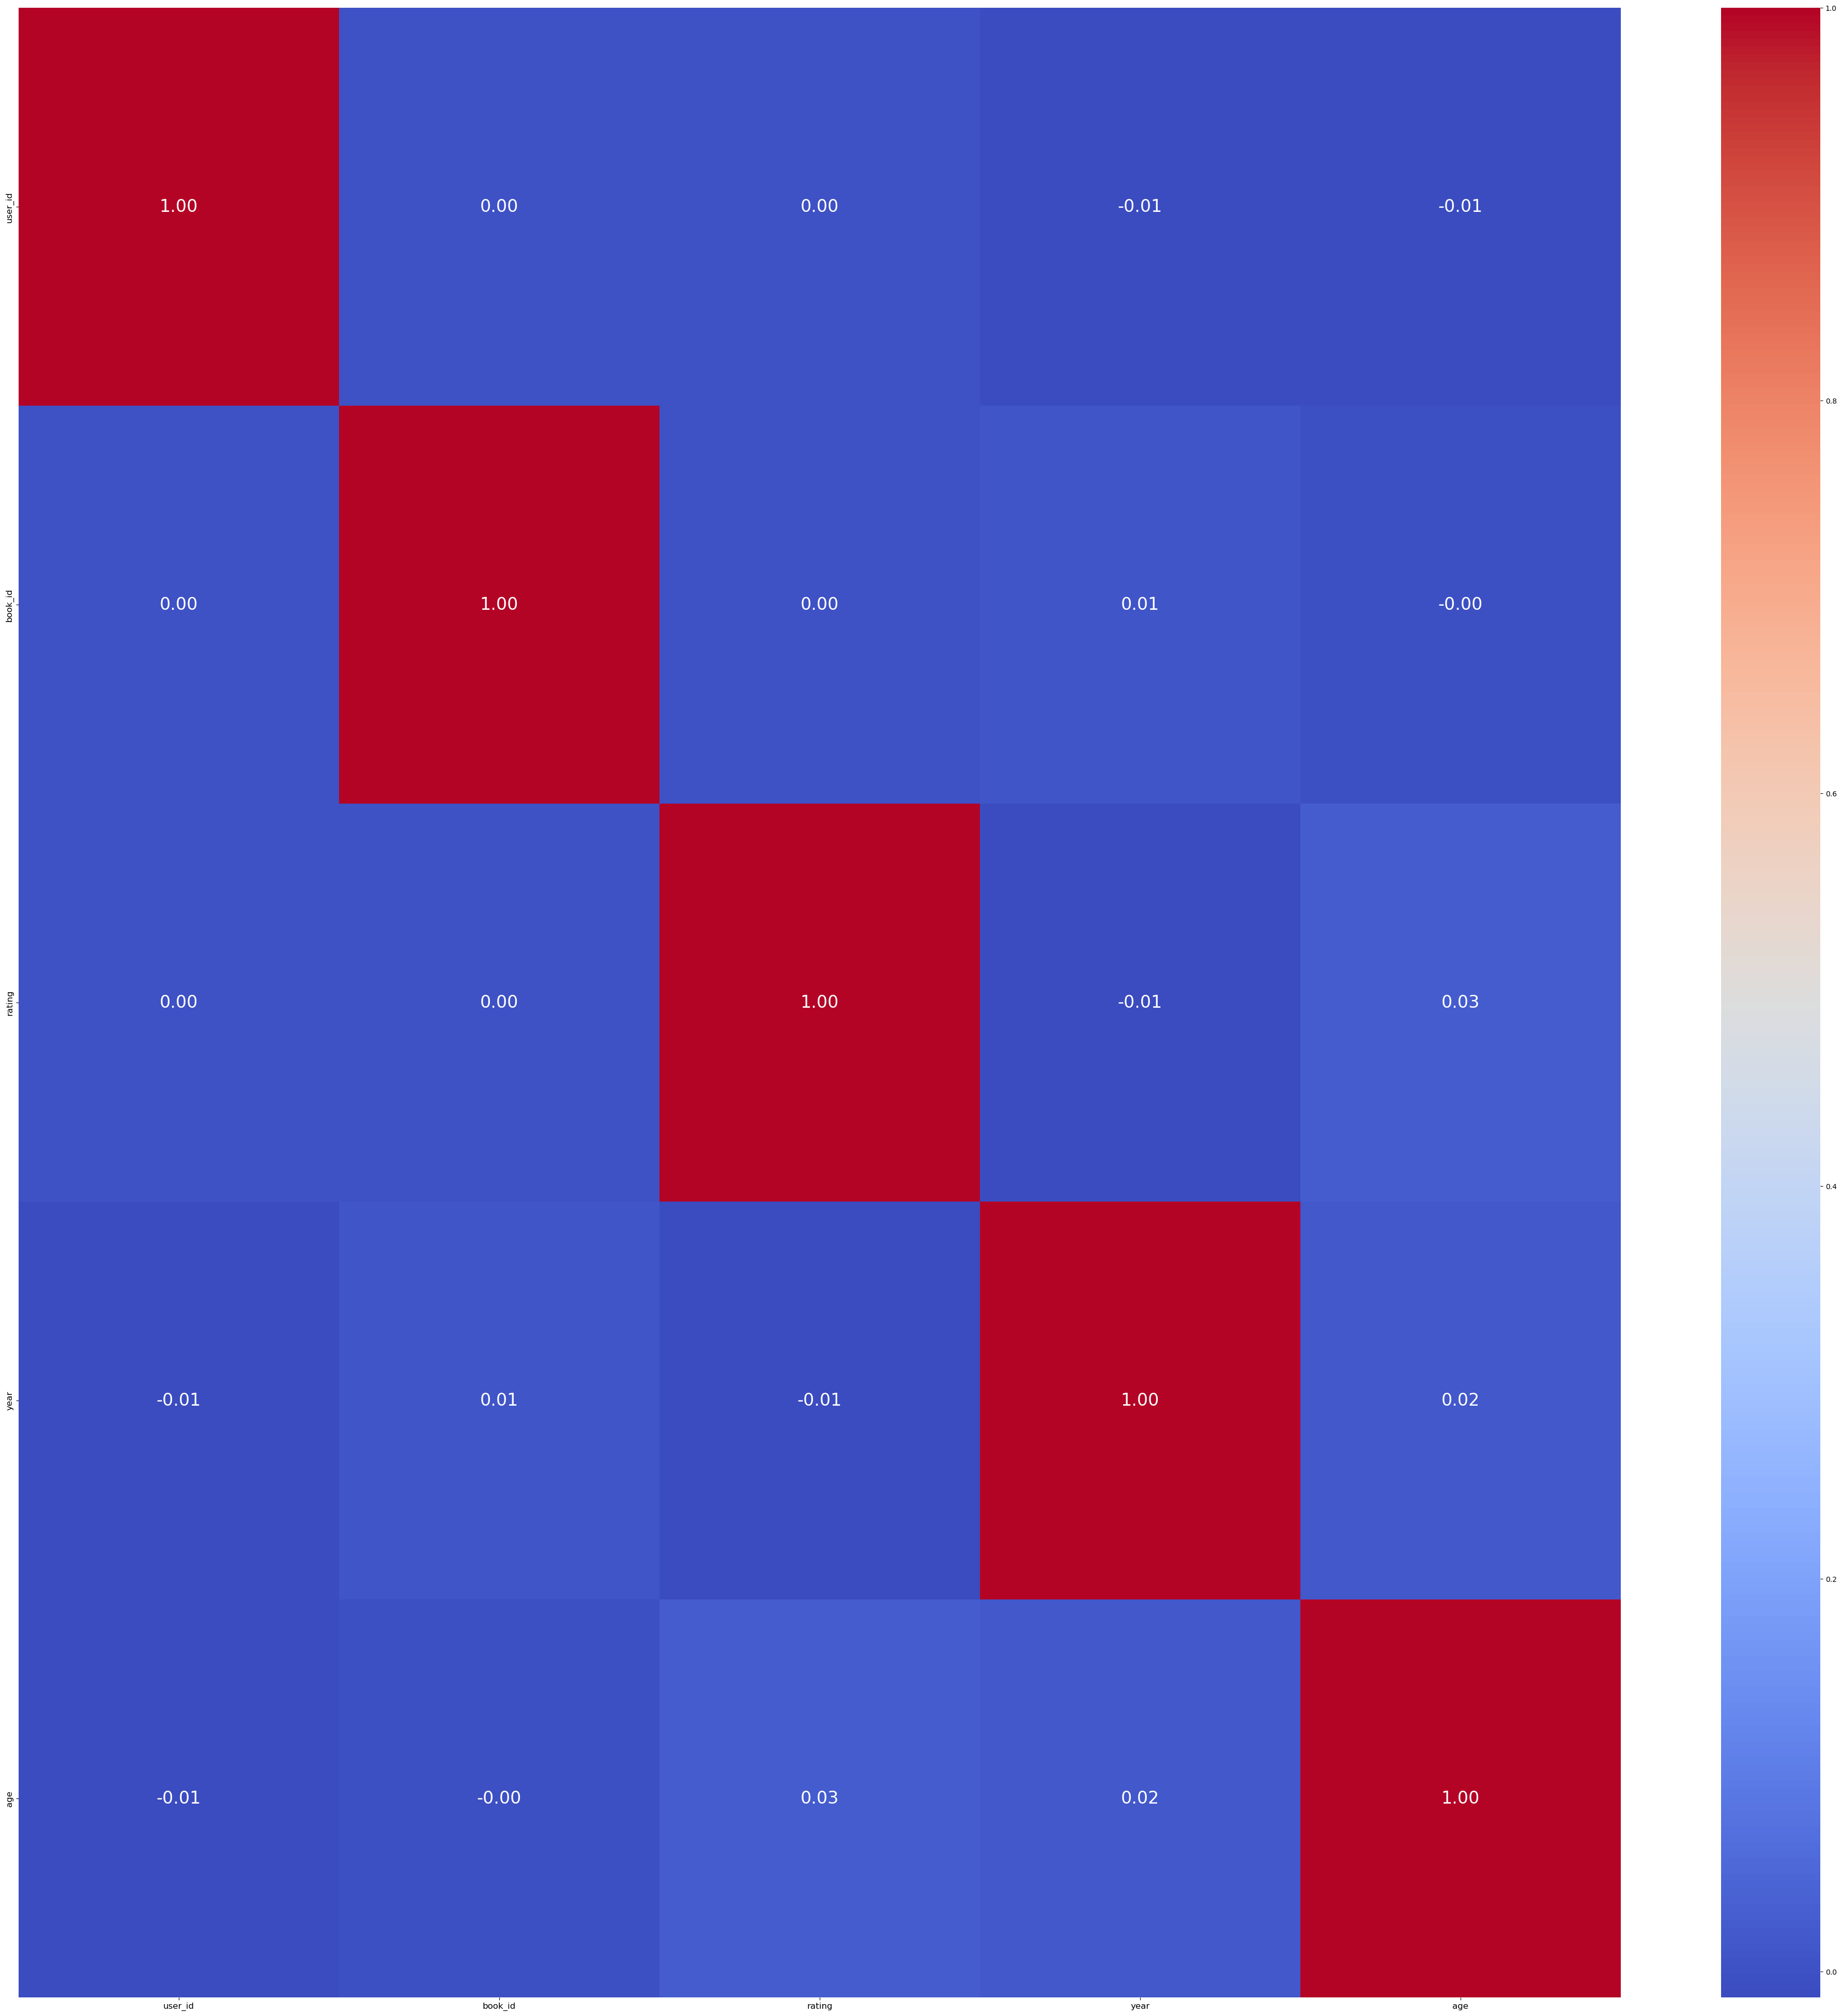

In [41]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(50, 50))

# plot correlation matrix
sns.heatmap(train_df.corr(), cmap='coolwarm', annot=True, fmt='.2f', annot_kws={'fontsize': 24})

# set tick label size
plt.tick_params(labelsize=12)

# save plot
plt.savefig('correlation_matrix_nn.png', dpi=150, bbox_inches='tight')

In [42]:
import numpy as np

# Embedding
embedding_index = {}
with open("./glove.6B.100d.txt", "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = coefs

embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [43]:
print(embedding_matrix.shape)

(100, 100)


In [47]:
from keras.preprocessing.text import Tokenizer

tokenizer_title = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer_title.fit_on_texts(train_df['title'])

In [48]:
from keras.utils import pad_sequences

train_sequences_title = tokenizer_title.texts_to_sequences(train_df['title'])
train_padded_title = pad_sequences(train_sequences_title, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences_title = tokenizer_title.texts_to_sequences(validation_df['title'])
validation_padded_title = pad_sequences(validation_sequences_title, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [66]:
from tensorflow.python.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Concatenate, Conv1D, GlobalMaxPooling1D
from keras.layers import BatchNormalization

# title embedding
title_input = Input(shape=(max_length,))
embedding_title = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length,
                            trainable=False)(title_input)
lstm1_title = LSTM(128, return_sequences=True)(embedding_title)
lstm2_title = LSTM(64)(lstm1_title)
conv1d_title = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding_title)
global_max_pooling_title = GlobalMaxPooling1D()(conv1d_title)
attention_layer_title = Attention(64)
lstm_output_title, _ = attention_layer_title(conv1d_title, global_max_pooling_title)
combined_output_title = Concatenate()([lstm_output_title, global_max_pooling_title, lstm2_title])

# Layers

In [67]:
num_input = Input(shape=(len(num_cols),))
dense_num = Dense(128, activation='relu')(num_input)

In [68]:
# Define the user_id input branch
user_id_input = Input(shape=(1,))
dense_user_id = Dense(128, activation="relu")(user_id_input)

# Define the book_id input branch
book_id_input = Input(shape=(1,))
dense_book_id = Dense(128, activation="relu")(book_id_input)

In [69]:
book_author_input = Input(shape=(1,))
dense_book_author = Dense(16, activation="relu")(book_author_input)

book_publisher_input = Input(shape=(1,))
dense_book_publisher = Dense(16, activation="relu")(book_publisher_input)

In [70]:
# Concatenate the branches
concat = Concatenate()([dense_num, dense_book_author, dense_book_publisher, combined_output_title])

In [71]:
dense1 = Dense(2048, activation="relu")(concat)
batch_norm = BatchNormalization()(dense1)
dropout = Dropout(0.2)(batch_norm)

dense2 = Dense(1024, activation="relu")(dropout)
dropout2 = Dropout(0.2)(dense2)

dense3 = Dense(512, activation="relu")(dropout2)
dropout3 = Dropout(0.2)(dense3)

dense4 = Dense(256, activation="relu")(dropout3)
dropout4 = Dropout(0.2)(dense4)

dense5 = Dense(128, activation="relu")(dropout4)
dropout5 = Dropout(0.2)(dense5)

# dense5 = Dense(128, activation="relu")(concat)
# batch_norm = BatchNormalization()(dense5)
# dropout5 = Dropout(0.2)(batch_norm)

dense6 = Dense(64, activation="relu")(dropout5)
dropout6 = Dropout(0.2)(dense6)

dense7 = Dense(32, activation="relu")(dropout6)
dropout7 = Dropout(0.2)(dense7)

In [72]:
# Define the output layer
output = Dense(1, activation="sigmoid")(dropout7)

In [74]:
from tensorflow.python.keras.models import Model

model = Model(inputs=[num_input, book_author_input, book_publisher_input, title_input], outputs=output)

In [75]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 100, 100)     10000       input_19[0][0]                   
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 98, 128)      38528       embedding_3[0][0]                
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 128)          0           conv1d_1[0][0]                   
______________________________________________________________________________________________

In [77]:
history = model.fit([X_train[num_cols], X_train['author'], X_train['publisher'], train_padded_title], train_df['rating'],
                    epochs=num_epochs, batch_size=batch_size, validation_data=([X_validation[num_cols], X_validation['author'], X_validation['publisher'], validation_padded_title], validation_df['actual_rating']))

2023-04-17 16:38:13.319229: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50


2023-04-17 16:38:15.238371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   5/2369 [..............................] - ETA: 22:58:23 - loss: 48.4187 - mean_absolute_error: 6.6885

KeyboardInterrupt: 